In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az

from mpl_toolkits.mplot3d import Axes3D

import pymc3 as pm
import pymc3.math as pmm
import theano
import theano.tensor as tt
import theano.tensor.fft as ttf

import seaborn as sns
sns.set_style('ticks')
sns.set_palette('colorblind')
sns.set_context('notebook')

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

All quantities follow [Cornish & Littenberg (2007)](http://dx.doi.org/10.1103/PhysRevD.76.083006)

In [3]:
# I sure hope L is in m
def Sn(fs, L=5e9):
    omegas = 2*pi*fs
    fstar = 2.99792e8/(2*pi*L)
    Sa = 1e-22/(L*L)
    Ss = 9e-30/(omegas*omegas*omegas*omegas)/(L*L)
    
    c2 = cos(2.0*fs/fstar)
    c = cos(fs/fstar)
    
    return 4.0/3.0*(1 - c2)*((2 + c)*Ss + 2*(3 + 2*c + c2)*Sa)

Text(0, 0.5, '$S_n(f)$ ($\\mathrm{Hz}^{-1}$)')

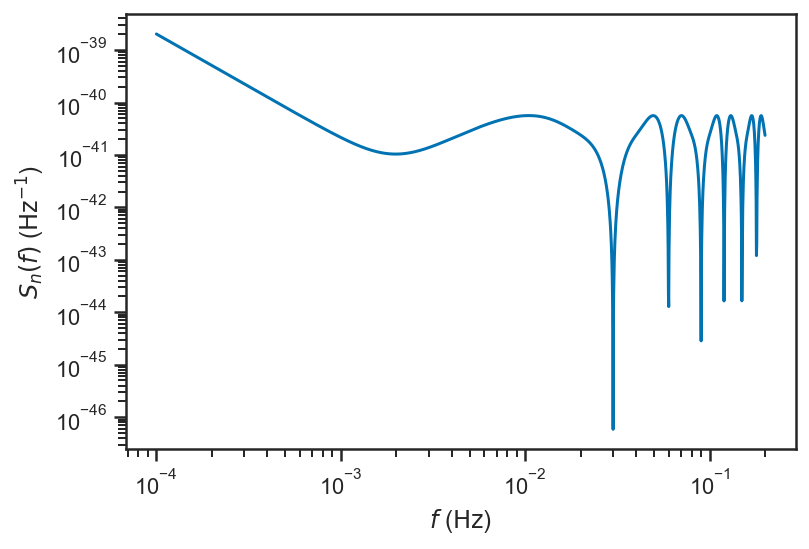

In [4]:
fs = exp(linspace(log(1e-4), log(2e-1), 2048))
loglog(fs, Sn(fs))
xlabel(r'$f$ ($\mathrm{Hz}$)')
ylabel(r'$S_n(f)$ ($\mathrm{Hz}^{-1}$)')

In [5]:
def constellation(ts, e=0.00985, R=1, kappa=0, lam=0):
    L = 5e9*2*sqrt(3)*e*R # m ; R in AU
    
    alpha = 2*pi*ts/(3600.0*24.0*365.25*R**(3.0/2.0)) + kappa
    alpha = tt.reshape(alpha, (1, alpha.shape[0]))
    
    betas = tt.as_tensor_variable([kappa, kappa + 2*pi/3, kappa + 4*pi/3])
    betas = tt.reshape(betas, (betas.shape[0], 1))
    
    xs = R*pmm.cos(alpha) + 0.5*e*R*(pmm.cos(2*alpha - betas) - 3*pmm.cos(betas))
    ys = R*pmm.sin(alpha) + 0.5*e*R*(pmm.sin(2*alpha - betas) - 3*pmm.sin(betas))
    zs = -sqrt(3)*e*R*pmm.cos(alpha - betas)
    
    return tt.stack((xs, ys, zs), axis=2)

(-0.1, 0.1)

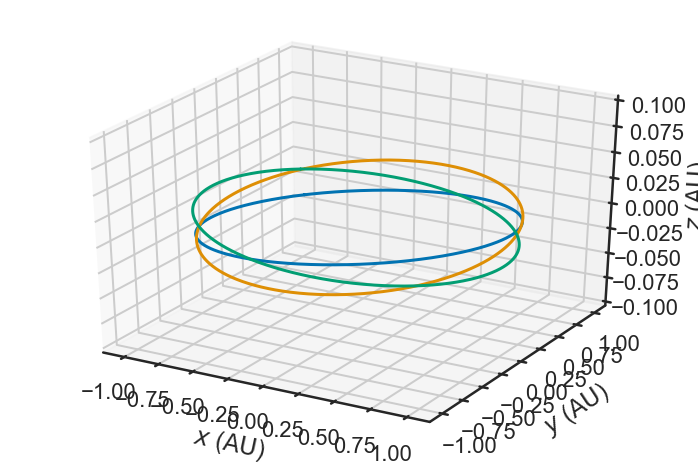

In [6]:
ts = linspace(0, 3600*24*365.25, 1024)
xyz = constellation(ts, lam=2*pi*rand(), kappa=2*pi*rand()).eval()
fig = figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    ax.plot(xyz[i,:,0], xyz[i,:,1], xyz[i,:,2])
ax.set_xlabel(r'$x$ ($\mathrm{AU}$)')
ax.set_ylabel(r'$y$ ($\mathrm{AU}$)')
ax.set_zlabel(r'$z$ ($\mathrm{AU}$)')
ax.set_zlim(-0.1, 0.1)

In [7]:
def uvk(nhat):
    phi = tt.arctan2(nhat[1], nhat[0])
    cos_theta = nhat[2]
    sin_theta = pmm.sqrt(1 - cos_theta*cos_theta)
    
    cphi = pmm.cos(phi)
    sphi = pmm.sin(phi)
    
    u = tt.as_tensor_variable([cos_theta*cphi, cos_theta*sphi, -sin_theta])
    v = tt.as_tensor_variable([sphi, -cphi, 0.0])
    k = tt.as_tensor_variable([-sin_theta*cphi, -sin_theta*sphi, -cos_theta])
    
    return tt.stack((u,v,k), dim=0)

In [8]:
def transfer(fs, ts, khat, xyz, L=5e9):
    khat = tt.reshape(khat, (1, 3))
    
    fstar = 2.99792e8 / (2*pi*L)
    
    tfs_re = tt.zeros((3,3,ts.shape[0]))
    tfs_im = tt.zeros((3,3,ts.shape[0]))
    for i in range(3):
        for j in range(i+1, 3):
            if not (j == i):
                rij = xyz[j,:,:] - xyz[i,:,:]
                r2 = tt.reshape(pmm.sum(rij*rij, axis=1), (-1, 1))
                rij = rij / pmm.sqrt(r2)
                
                rk = pmm.sum(rij*khat, axis=1)
                w = fs/(2*fstar)*(1-rk)
                wp = fs/(2*fstar)*(1+rk) # Reverse direction, get a plus
                sc = pmm.sin(w)/w
                scp = pmm.sin(wp)/wp

                tfs_re = tt.set_subtensor(tfs_re[i,j,:], sc*pmm.cos(w))
                tfs_im = tt.set_subtensor(tfs_im[i,j,:], sc*pmm.sin(w))
                
                tfs_re = tt.set_subtensor(tfs_re[j,i,:], scp*pmm.cos(wp))
                tfs_im = tt.set_subtensor(tfs_im[j,i,:], scp*pmm.sin(wp))
        
    return tfs_re, tfs_im

In [9]:
ts = linspace(0, pi*1e7, 1024)
fs = 1e-3*ones_like(ts)
uvk_ = uvk([1.0, 0.0, 0.0])
khat = uvk_[2,:]
xyz = constellation(ts)

tfs_re, tfs_im = transfer(fs, ts, khat, xyz)
tfs_re = tfs_re.eval()
tfs_im = tfs_im.eval()

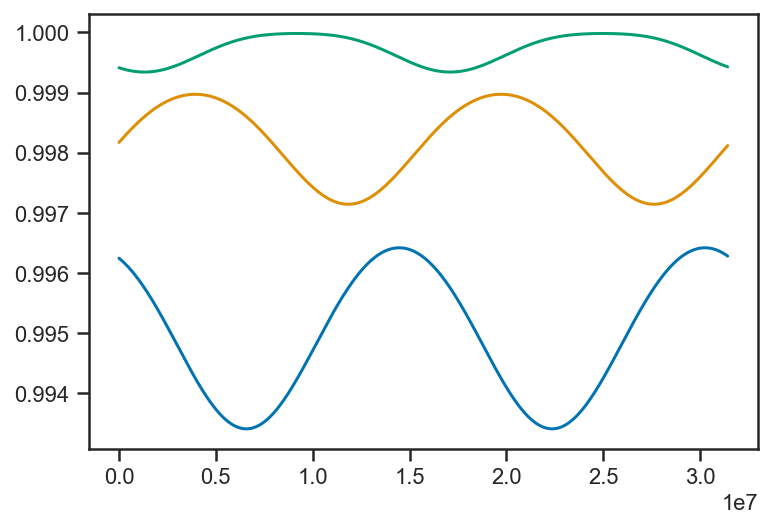

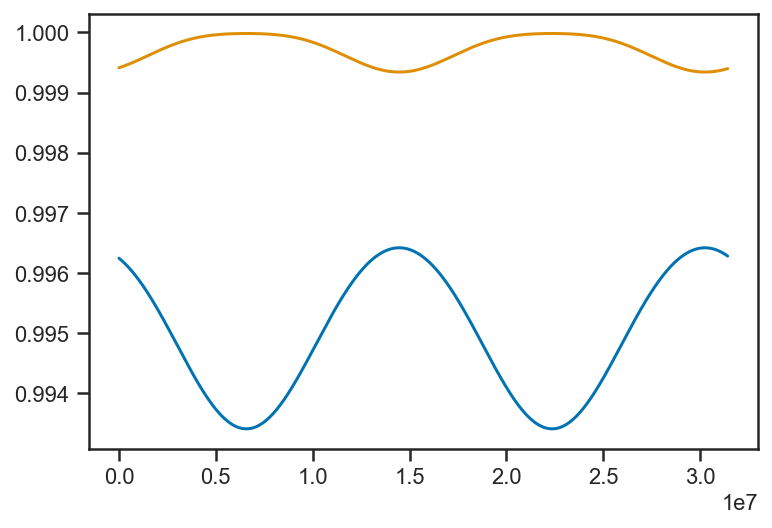

In [10]:
plot(ts, tfs_re[0,1,:])
plot(ts, tfs_re[1,2,:])
plot(ts, tfs_re[2,0,:])

figure()
plot(ts, tfs_re[0,1,:])
plot(ts, tfs_re[1,0,:])

In [11]:
def dp_dc(xyz, uvk):
    dps = tt.zeros((3,3,xyz.shape[1]))
    dcs = tt.zeros((3,3,xyz.shape[1]))
    for i in range(3):
        for j in range(i+1,3):
            rij = xyz[j,:,:] - xyz[i,:,:]
            r2 = pmm.sum(rij*rij, axis=1)
            rij = rij / tt.reshape(pmm.sqrt(r2), (-1, 1))

            ru = pmm.sum(rij*uvk[0,:], axis=1)
            rv = pmm.sum(rij*uvk[1,:], axis=1)

            dps = tt.set_subtensor(dps[i,j,:], ru*ru - rv*rv)
            dcs = tt.set_subtensor(dcs[i,j,:], ru*rv + ru*rv)
            dps = tt.set_subtensor(dps[j,i,:], dps[i,j,:])
            dcs = tt.set_subtensor(dcs[j,i,:], dcs[i,j,:])
        
    return dps, dcs

In [12]:
ts = linspace(0, pi*1e7, 1024)
dps, dcs = dp_dc(constellation(ts), uvk([1.0, 0.0, 0.0]))
dps = dps.eval()
dcs = dcs.eval()

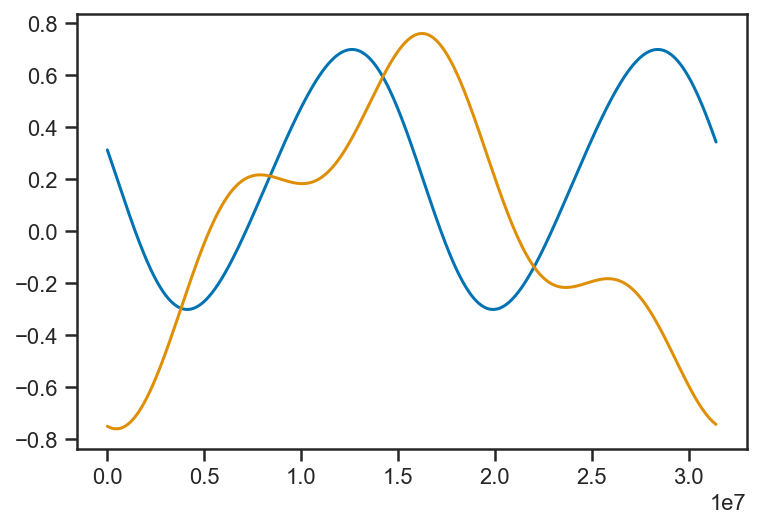

In [13]:
plot(ts, dps[0,1,:])
plot(ts, dcs[0,1,:])

In [14]:
def Ap_Ac(fs, cos_iota):
    cos_iota2 = cos_iota*cos_iota
    fs23 = (pi*fs/1e-3)**(2.0/3.0)
    
    return (2.0*fs23*(1+cos_iota2), -4.0*fs23*cos_iota)

In [15]:
def y_slow(ts, f0, fdot, phi0, nhat, cos_iota, psi, fhet=None):
    if fhet is None:
        fhet = f0
        
    df = f0 - fhet
    
    uvk_ = uvk(nhat)
    khat = uvk_[2,:]
    
    xyz = constellation(ts)
    
    dp, dc = dp_dc(xyz, uvk_)
    
    cp = pmm.cos(2.0*psi)
    sp = pmm.sin(2.0*psi)
    
    ys_re = tt.zeros((3, 3, ts.shape[0]))
    ys_im = tt.zeros((3, 3, ts.shape[0]))
    
    for i in range(3):
        kdotx = 499.0048*tt.tensordot(xyz[i,:,:], khat, axes=1) # 499.0048 = 1 AU / c in seconds
        xi = ts - kdotx
        fs = f0 + fdot*xi
        
        tfs_re, tfs_im = transfer(fs, ts, khat, xyz)
        Ap, Ac = Ap_Ac(fs, cos_iota)
        
        phi = pi*fdot*xi*xi + phi0 - 2*pi*f0*kdotx + 2*pi*df*ts
        osc_re = pmm.cos(phi)
        osc_im = pmm.sin(phi)
        
        for j in range(3):
            if not i == j:
                Fp_re = dp[i,j]*Ap*cp - dc[i,j]*Ap*sp
                Fp_im = -dp[i,j]*Ac*sp - dc[i,j]*Ac*cp

                A_re = (Fp_re*tfs_re[i,j,:] - Fp_im*tfs_im[i,j,:])/4
                A_im = (Fp_im*tfs_re[i,j,:] + Fp_re*tfs_im[i,j,:])/4
        
                ys_re = tt.set_subtensor(ys_re[i,j,:], A_re*osc_re - A_im*osc_im)
                ys_im = tt.set_subtensor(ys_im[i,j,:], A_im*osc_re + A_re*osc_im)
                
    return (ys_re, ys_im)

In [16]:
def slow_bw(f0, fdot, Tobs, R=1):
    fm = 1.0/(3600.0*24.0*365.25*R**(3.0/2.0))
    
    return 2*(4 + 2*pi*f0*R*499.0047)*fm + abs(fdot*Tobs)  # 499.0047 is 1 AU in seconds

In [17]:
def next_pow_two(N):
    i = 1
    while i < N:
        i = i << 1
    return i

Because we use a fairly minimal number of samples (only twice "Nyquist" of $2*B*T_\mathrm{obs}$), the curve below looks pretty jagged.

In [32]:
f0 = 1e-3
fdot = f0*1e-6/(3600.0*24.0*365.25)
phi0 = 0.0
cos_iota = 1.0
psi = 0.0
nhat = tt.as_tensor_variable(array([1.0, 0.0, 0.0]))
Tobs = 2*pi*1e7

hbin = int(round((f0*Tobs)))
N = next_pow_two(int(round(4*Tobs*slow_bw(f0, fdot, Tobs))))

ts = linspace(0, Tobs, N)

ys_re, ys_im = y_slow(ts, f0, fdot, phi0, nhat, cos_iota, psi)
ys_re = ys_re.eval()
ys_im = ys_im.eval()

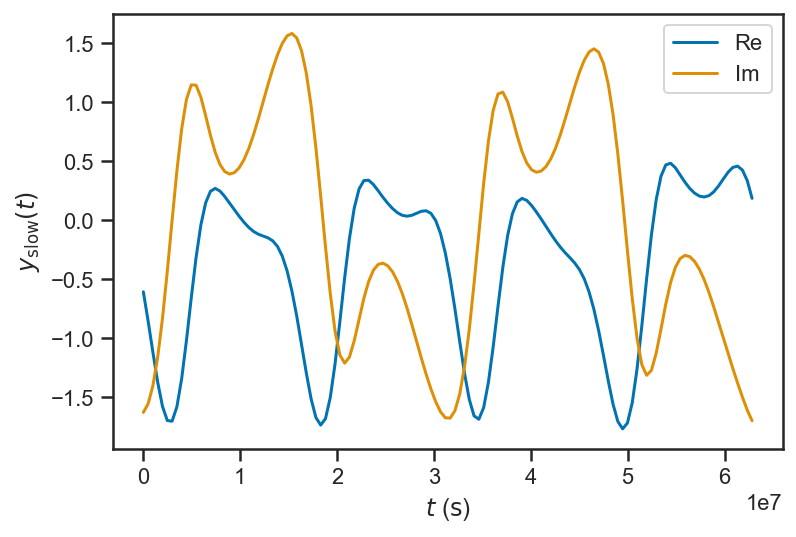

In [19]:
plot(ts, ys_re[0,2,:], label='Re')
plot(ts, ys_im[0,2,:], label='Im')

xlabel(r'$t$ ($\mathrm{s}$)')
ylabel(r'$y_\mathrm{slow}(t)$')

legend(loc='best')

In [20]:
def y_fd(t0, Tobs, f0, fdot, phi0, nhat, cos_iota, psi, heterodyne_bin, N):
    fhet = heterodyne_bin/Tobs
    
    ts = t0 + linspace(0, Tobs, N+1)[:-1]
    
    ys_re, ys_im = y_slow(ts, f0, fdot, phi0, nhat, cos_iota, psi, fhet=fhet)
        
    ys_re_rfft = ttf.rfft(tt.reshape(ys_re, (-1,N)))
    ys_im_rfft = ttf.rfft(tt.reshape(ys_im, (-1,N)))
    
    NN = N//2 + 1
    
    ys_re_rfft = tt.reshape(ys_re_rfft, (3,3,NN,2))
    ys_im_rfft = tt.reshape(ys_im_rfft, (3,3,NN,2))
    
    y_fd_re = tt.zeros((3,3,N))
    y_fd_im = tt.zeros((3,3,N))
    
    y_fd_re = tt.set_subtensor(y_fd_re[:,:,:NN], ys_re_rfft[:,:,:,0] - ys_im_rfft[:,:,:,1])
    y_fd_im = tt.set_subtensor(y_fd_im[:,:,:NN], ys_re_rfft[:,:,:,1] + ys_im_rfft[:,:,:,0])
    
    y_fd_re = tt.set_subtensor(y_fd_re[:,:,NN:], ys_re_rfft[:,:,-2:0:-1,0] + ys_im_rfft[:,:,-2:0:-1,1])
    y_fd_im = tt.set_subtensor(y_fd_im[:,:,NN:], -ys_re_rfft[:,:,-2:0:-1,1] + ys_im_rfft[:,:,-2:0:-1,0])
    
    return 0.5*(ts[1]-ts[0])*y_fd_re, 0.5*(ts[1]-ts[0])*y_fd_im

In [21]:
yf_re, yf_im = y_fd(0.0, Tobs, f0, fdot, phi0, nhat, cos_iota, psi, hbin, N)
yf_re = yf_re.eval()
yf_im = yf_im.eval()

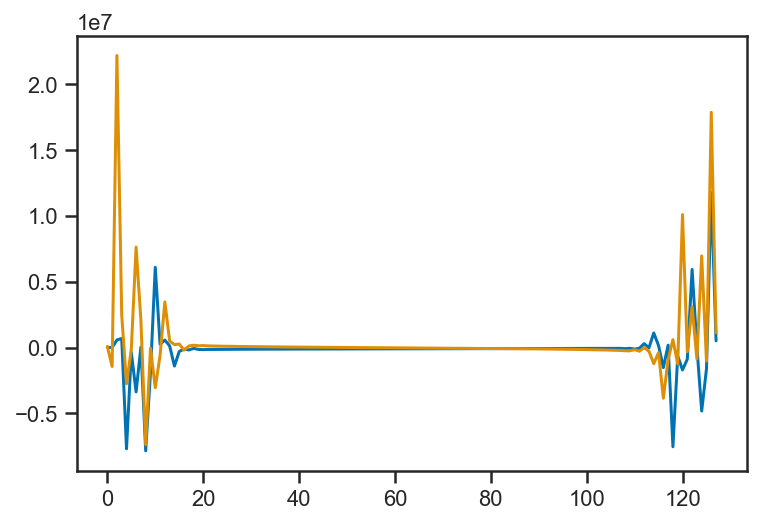

In [22]:
plot(yf_re[0,1,:])
plot(yf_im[0,1,:])

In [23]:
def XYZ_freq(yf_re, yf_im, Tobs, heterodyne_bin, N, L=5e9):
    fstar = 2.99792e8/(2.0*pi*L)
    
    nf = N
    df = 1.0/Tobs
    dfs = linspace(0, df*nf/2, int(round(nf/2))+1)
    dfs = concatenate((dfs, -dfs[-2:0:-1]))
    fs = heterodyne_bin*df + dfs
    
    c1 = pmm.cos(-fs/fstar)
    s1 = pmm.sin(-fs/fstar)
    
    c2 = pmm.cos(-2*fs/fstar)
    s2 = pmm.sin(-2*fs/fstar)
    
    c3 = pmm.cos(-3*fs/fstar)
    s3 = pmm.sin(-3*fs/fstar)
        
    X_re = yf_re[0,1,:]*c3 - yf_im[0,1,:]*s3 \
           - (yf_re[0,2,:]*c3 - yf_im[0,2,:]*s3) \
           + yf_re[1,0,:]*c2 - yf_im[1,0,:]*s2 \
           - (yf_re[2,0,:]*c2 - yf_im[2,0,:]*s2) \
           + yf_re[0,2,:]*c1 - yf_im[0,2,:]*s1 \
           - (yf_re[0,1,:]*c1 - yf_im[0,1,:]*s1) \
           + yf_re[2,0,:] - yf_re[1,0,:]
    
    X_im = yf_im[0,1,:]*c3 + yf_re[0,1,:]*s3 \
           - (yf_im[0,2,:]*c3 + yf_re[0,2,:]*s3) \
           + yf_im[1,0,:]*c2 + yf_re[1,0,:]*s2 \
           - (yf_im[2,0,:]*c2 + yf_re[2,0,:]*s2) \
           + yf_im[0,2,:]*c1 + yf_re[0,2,:]*s1 \
           - (yf_im[0,1,:]*c1 + yf_re[0,1,:]*s1) \
           + yf_im[2,0,:] - yf_im[1,0,:]
    
    Y_re = yf_re[1,2,:]*c3 - yf_im[1,2,:]*s3 \
           - (yf_re[1,0,:]*c3 - yf_im[1,0,:]*s3) \
           + yf_re[2,1,:]*c2 - yf_im[2,1,:]*s2 \
           - (yf_re[0,1,:]*c2 - yf_im[0,1,:]*s2) \
           + yf_re[1,0,:]*c1 - yf_im[1,0,:]*s1 \
           - (yf_re[1,2,:]*c1 - yf_im[1,2,:]*s1) \
           + yf_re[0,1,:] - yf_re[2,1,:]
    
    Y_im = yf_im[1,2,:]*c3 + yf_re[1,2,:]*s3 \
           - (yf_im[1,0,:]*c3 + yf_re[1,0,:]*s3) \
           + yf_im[2,1,:]*c2 + yf_re[2,1,:]*s2 \
           - (yf_im[0,1,:]*c2 + yf_re[0,1,:]*s2) \
           + yf_im[1,0,:]*c1 + yf_re[1,0,:]*s1 \
           - (yf_im[1,2,:]*c1 + yf_re[1,2,:]*s1) \
           + yf_im[0,1,:] - yf_im[2,1,:]
    
    Z_re = yf_re[2,0,:]*c3 - yf_im[2,0,:]*s3 \
           - (yf_re[2,1,:]*c3 - yf_im[2,1,:]*s3) \
           + yf_re[0,2,:]*c2 - yf_im[0,2,:]*s2 \
           - (yf_re[1,2,:]*c2 - yf_im[1,2,:]*s2) \
           + yf_re[2,1,:]*c1 - yf_im[2,1,:]*s1 \
           - (yf_re[2,0,:]*c1 - yf_im[2,0,:]*s1) \
           + yf_re[1,2,:] - yf_re[0,2,:]
    
    Z_im = yf_im[1,2,:]*c3 + yf_re[1,2,:]*s3 \
           - (yf_im[1,0,:]*c3 + yf_re[1,0,:]*s3) \
           + yf_im[2,1,:]*c2 + yf_re[2,1,:]*s2 \
           - (yf_im[0,1,:]*c2 + yf_re[0,1,:]*s2) \
           + yf_im[1,0,:]*c1 + yf_re[1,0,:]*s1 \
           - (yf_im[1,2,:]*c1 + yf_re[1,2,:]*s1) \
           + yf_im[0,1,:] - yf_im[2,1,:]
    
    return ((X_re, X_im), (Y_re, Y_im), (Z_re, Z_im))

In [24]:
def AET_XYZ(X_re, X_im, Y_re, Y_im, Z_re, Z_im):
    A_re = 1.0/3.0*(2.0*X_re - Y_re - Z_re)
    A_im = 1.0/3.0*(2.0*X_im - Y_im - Z_im)
    
    E_re = 1.0/sqrt(3.0)*(Z_re - Y_re)
    E_im = 1.0/sqrt(3.0)*(Z_im - Y_im)
    
    T_re = 1.0/3.0*(X_re + Y_re + Z_re)
    T_im = 1.0/3.0*(X_im + Y_im + Z_im)
    
    return ((A_re, A_im), (E_re, E_im), (T_re, T_im))

In [33]:
((X_re, X_im), (Y_re, Y_im), (Z_re, Z_im)) = XYZ_freq(yf_re, yf_im, Tobs, hbin, N)
((A_re, A_im), (E_re, E_im), (T_re, T_im)) = AET_XYZ(X_re, X_im, Y_re, Y_im, Z_re, Z_im)

A_re = A_re.eval()
A_im = A_im.eval()
E_re = E_re.eval()
E_im = E_im.eval()

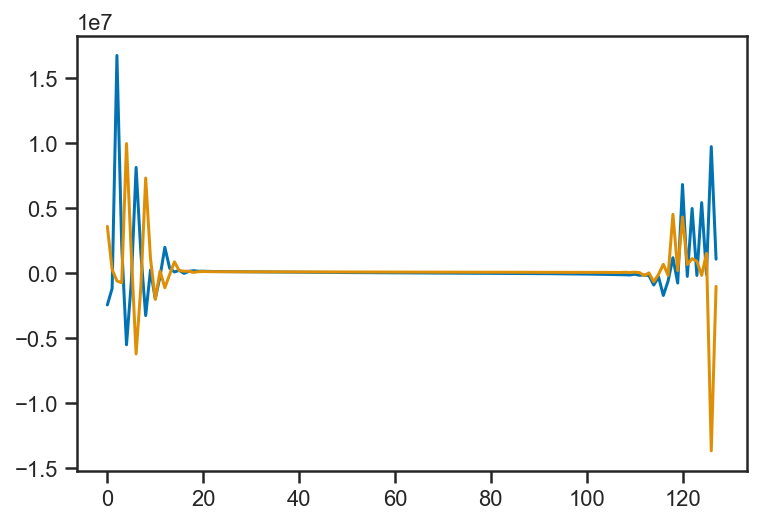

In [26]:
plot(A_re)
plot(A_im)

In [34]:
S0 = Sn(f0)
lnA = 0.5*(log(100.0) + log(S0) - log((2.0*Tobs)))
A = exp(lnA)

f_het = f0
sigma_f = 10/Tobs

A_re_data = A_re*A
A_im_data = A_im*A
E_re_data = E_re*A
E_im_data = E_im*A

In [28]:
with pm.Model() as model:
    sigma = sqrt(Tobs*S0/4.0)
    hbin = int(round(f_het*Tobs))
    lnAlow = 0.5*(log(S0) - log(2*Tobs))
    lnAhigh = lnAlow + log(1000)
    
    f0_unit = pm.Normal('f0-unit', mu=0, sigma=1)
    f0 = pm.Deterministic('f0', f_het + sigma_f*f0_unit)
    
    fdot_unit = pm.Normal('fdot-unit', mu=0.0, sigma=1.0)
    fdot = pm.Deterministic('fdot', sigma_f/Tobs*fdot_unit)
    
    cos_iota = pm.Uniform('cos_iota', lower=-1, upper=1)
    iota = pm.Deterministic('iota', tt.arccos(cos_iota))
    
    n_psi = pm.Normal('n_psi', mu=zeros(2), sigma=ones(2), shape=(2,))
    psi = pm.Deterministic('psi', tt.arctan2(n_psi[1], n_psi[0]))
    
    n_ra_dec = pm.Normal('n_ra_dec', mu=zeros(3), sigma=ones(3), shape=(3,))
    nhat = pm.Deterministic('nhat', n_ra_dec / pmm.sqrt(tt.tensordot(n_ra_dec, n_ra_dec, axes=1)))
    ra = pm.Deterministic('ra', tt.arctan2(n_ra_dec[1], n_ra_dec[0]))
    dec = pm.Deterministic('dec', pi/2 - tt.arccos(nhat[2]))
    
    n_phi0 = pm.Normal('n_phi0', mu=zeros(2), sigma=ones(2), shape=(2,))
    phi0 = pm.Deterministic('phi0', tt.arctan2(n_phi0[1], n_phi0[0]))
    
    lnA = pm.Uniform('lnA', lower=lnAlow, upper=lnAhigh)
    A = pm.Deterministic('A', pmm.exp(lnA))
    
    y_re, y_im = y_fd(0.0, Tobs, f0, fdot, phi0, nhat, cos_iota, psi, hbin, N)
    ((X_re, X_im), (Y_re, Y_im), (Z_re, Z_im)) = XYZ_freq(y_re, y_im, Tobs, hbin, N)
    ((A_re, A_im), (E_re, E_im), (T_re, T_im)) = AET_XYZ(X_re, X_im, Y_re, Y_im, Z_re, Z_im)
    
    A_re = pm.Deterministic('A_re', A*A_re)
    A_im = pm.Deterministic('A_im', A*A_im)
    E_re = pm.Deterministic('E_re', A*E_re)
    E_im = pm.Deterministic('E_im', A*E_im)
    
    snr = pm.Deterministic('SNR', tt.sum(tt.square(A_re/sigma)) + tt.sum(tt.square(A_im/sigma)) + tt.sum(tt.square(E_re/sigma)) + tt.sum(tt.square(E_im/sigma)))

    _ = pm.Normal('A_re_obs', mu=A_re, sigma=sigma, observed=A_re_data, shape=(A_re_data.shape[0],))
    _ = pm.Normal('A_im_obs', mu=A_im, sigma=sigma, observed=A_im_data, shape=(A_im_data.shape[0],))
    _ = pm.Normal('E_re_obs', mu=E_re, sigma=sigma, observed=E_re_data, shape=(E_re_data.shape[0],))
    _ = pm.Normal('E_im_obs', mu=E_im, sigma=sigma, observed=E_im_data, shape=(E_im_data.shape[0],))

In [29]:
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=3, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [lnA, n_phi0, n_ra_dec, n_psi, cos_iota, fdot-unit, f0-unit]
Sampling 3 chains, 1 divergences: 100%|██████████| 6000/6000 [13:03<00:00,  7.65draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [39]:
exp(lnAhigh)

4.1434379726353113e-22

In [30]:
fit = az.from_pymc3(trace)

Because I have foolishly named the variables in the model, you will have to re-run the cells above that define `f0`, etc, before executing the this plot (the original variables are overwritten w/i the `with pm.Model() ...` block.  It is clear that two of the three chains have converged to the correct value; the other got there at the end of the run, but isn't quite there at the beginning.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127f46a90>,
      dtype=object)

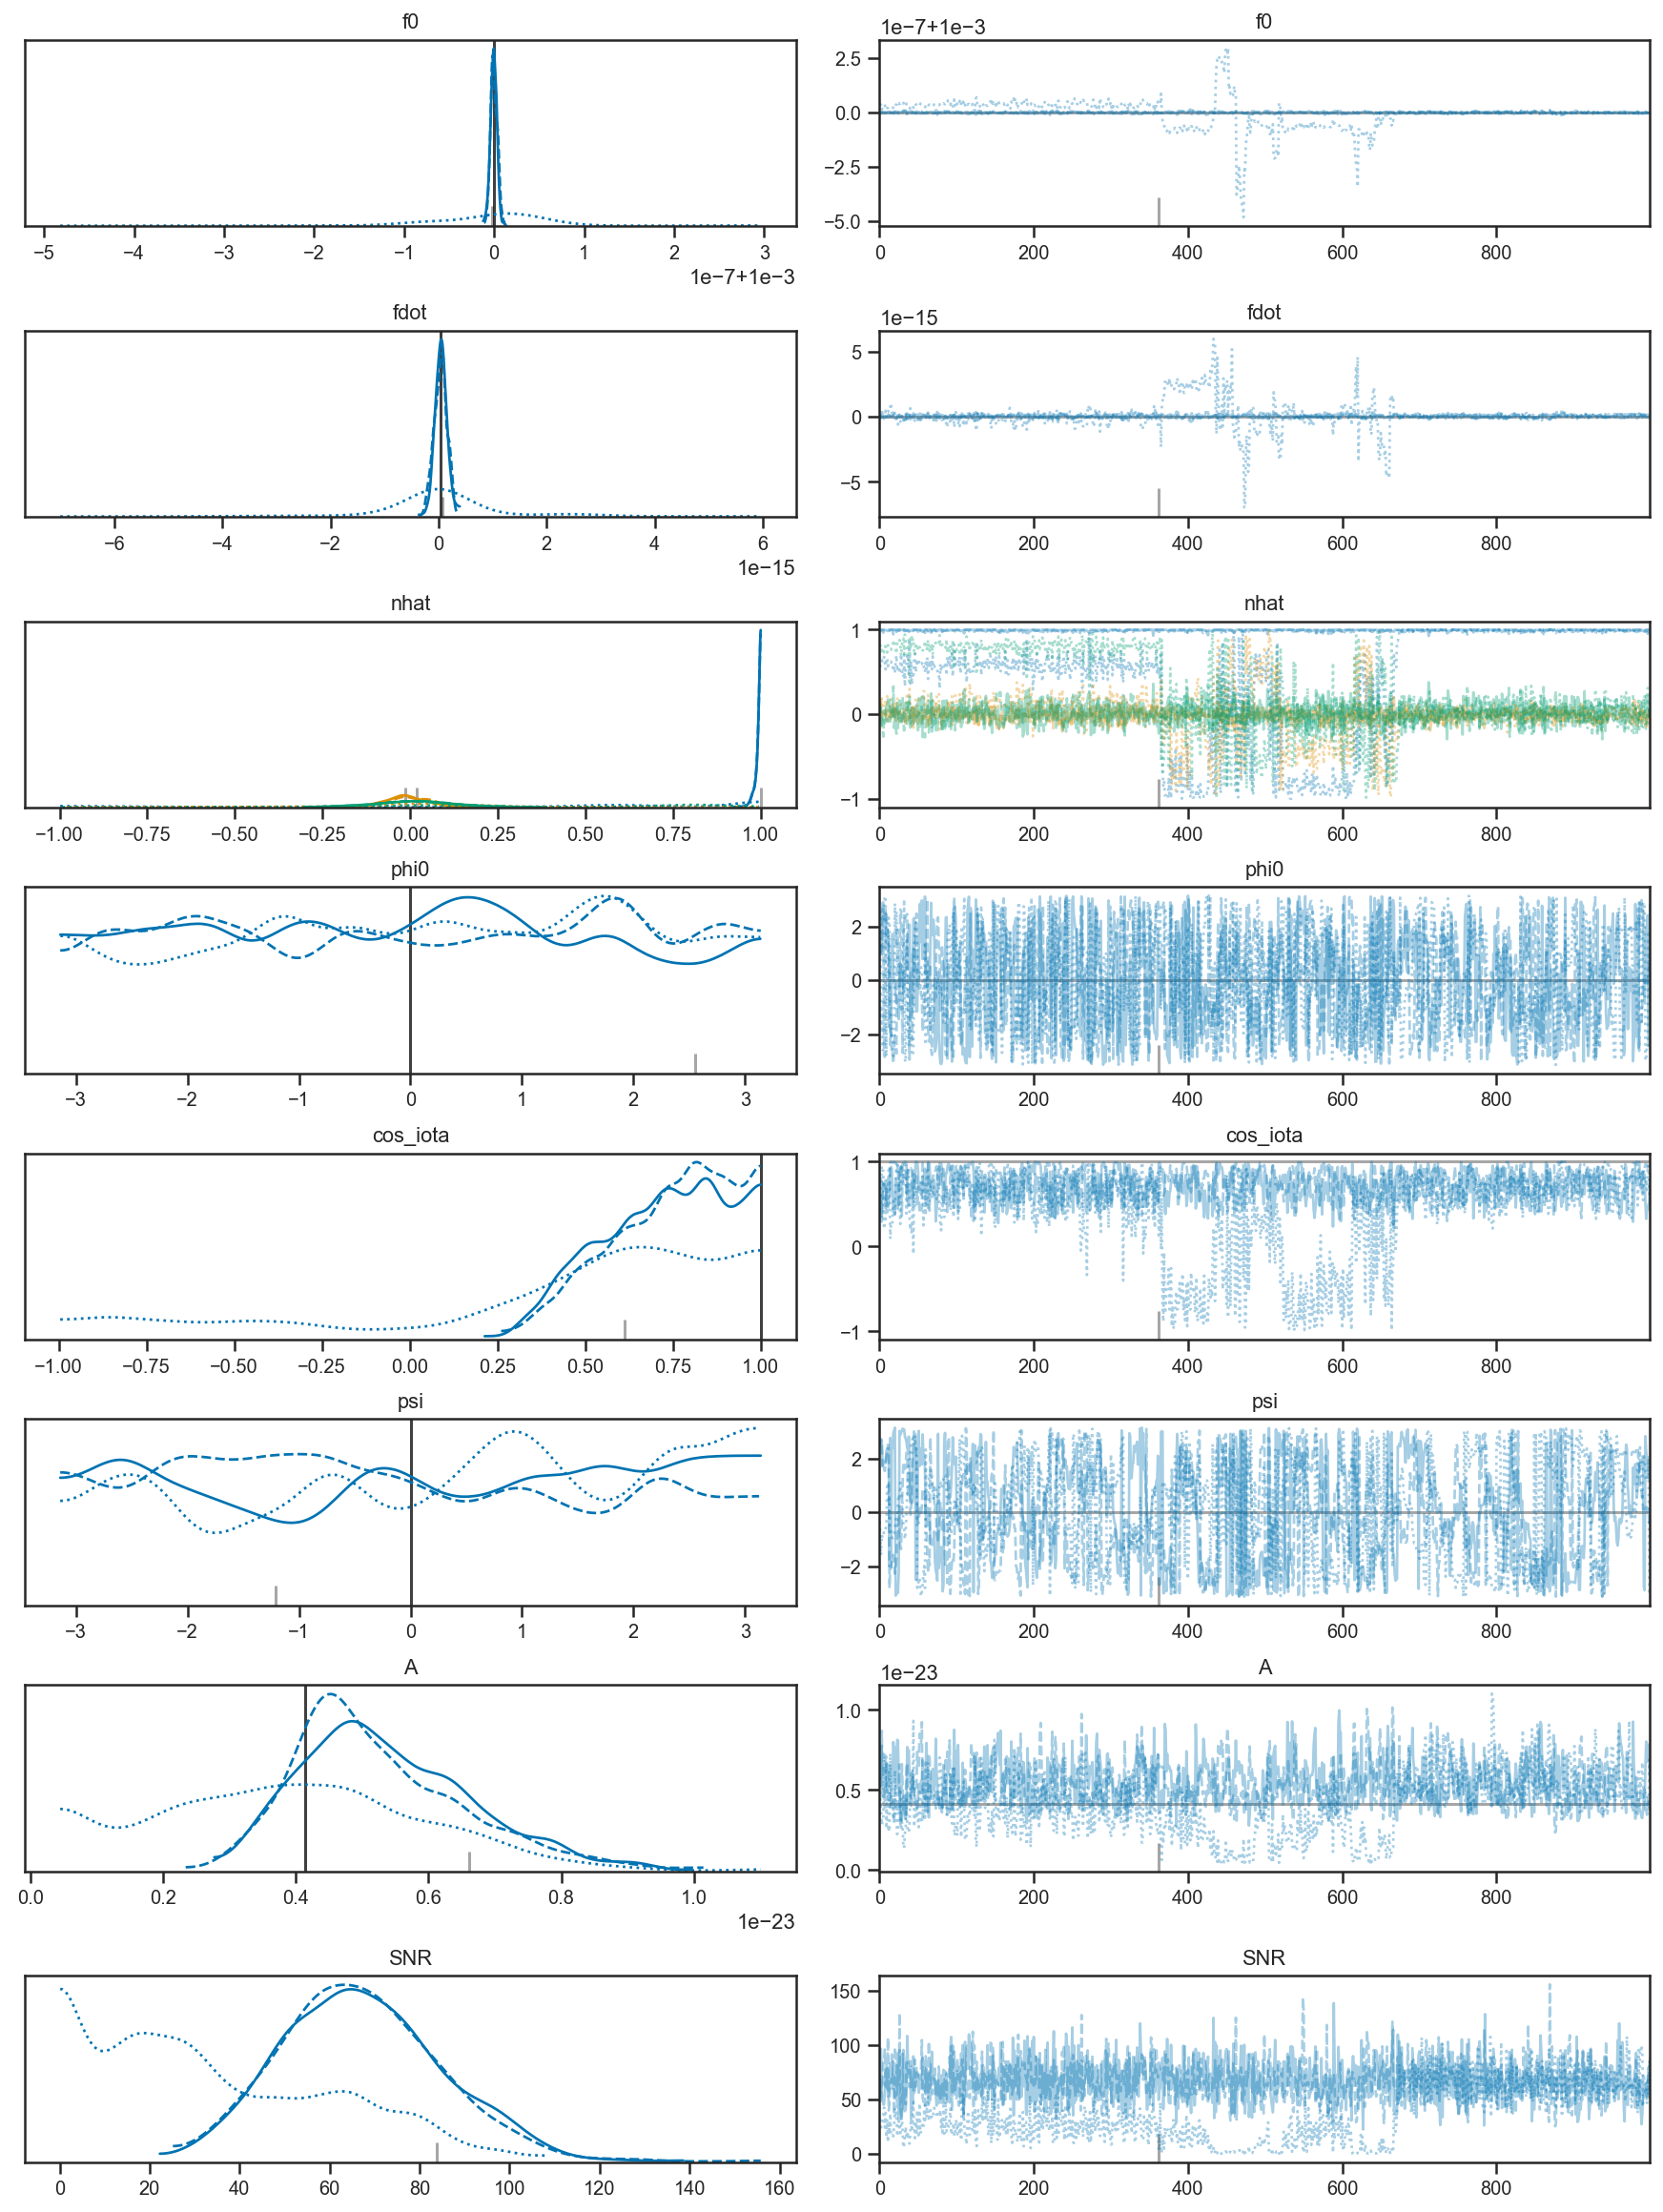

In [42]:
az.plot_trace(fit, compact=True, var_names=['f0', 'fdot', 'nhat', 'phi0', 'cos_iota', 'psi', 'A', 'SNR'],
              lines=(('f0', {}, f0), ('fdot', {}, fdot), 
                     ('nhat', {'nhat_dim_0': [0,1,2]}, nhat.eval()), ('phi0', {}, phi0), ('cos_iota', {}, cos_iota), ('psi', {}, psi), ('A', {}, A)))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1299d4290>,
      dtype=object)

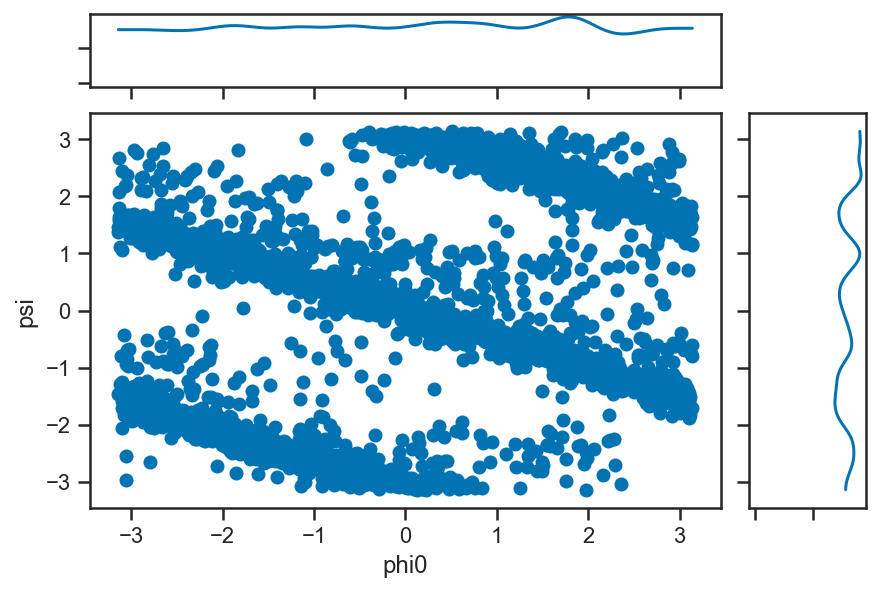

In [40]:
az.plot_joint(fit, var_names=['phi0', 'psi'])